In [ ]:
import csv

destinations_navigo = {}
with open('../../data/navigo_all_flows_1787.csv', newline='') as csvfile:
  flows = csv.DictReader(csvfile)
  commodity_fields = ['commodity_standardized_fr', 'commodity_standardized2_fr', 'commodity_standardized3_fr', 'commodity_standardized4_fr']
  stop_commodities = set(['lest', 'lège', 'vide', 'futailles vides'])
  total_commodities = set()
  for flow in flows:
    destination = flow['destination_partner_balance_1789']
    transformation_map = {
      'Quatre villes hanséatiques': 'Villes hanséatiques',
      'Etats-Unis': 'États-Unis d\'Amérique',
      # 'Etats de l\'Empereur':''
    }
    if destination in transformation_map:
      destination = transformation_map[destination]
    departure = flow['departure_state_1789_fr']
    tonnage = float(flow['tonnage'] or 0)
    if flow['departure_function'] == 'O' \
      and departure == 'France' \
      and destination != '' \
      and destination != 'France' \
      and flow['destination_state_1789_fr'] != 'France' :
      commodities = [flow[field].lower() for field in commodity_fields if flow[field] != '']
      not_stop = [commodity for commodity in commodities if commodity not in stop_commodities]
      if len(commodities) == 0 or len(not_stop) > 0:
        for c in not_stop:
          total_commodities.add(c)
        # print(departure + '->' + destination, flow['tonnage'] + '->' + str(tonnage))
        # at this point we have all the flows we want
        if destination not in destinations_navigo:
          destinations_navigo[destination] = 0
        destinations_navigo[destination] += tonnage
print('destinations navigo:')
print(destinations_navigo)

In [ ]:
print('\n'.join([{"destination": destination, "tonnage": tonnage} for destination, tonnage in destinations_navigo.items()]))

In [ ]:
from IPython.display import display
import pandas as pd

def VegaLite(spec):
    bundle = {}
    bundle['application/vnd.vegalite.v4+json'] = spec
    display(bundle, raw=True)

In [56]:
import json

with open("data/import_export_ports_francs.json", "r") as f:
    data = json.load(f)

In [53]:
SORT_LABELS = ["colonies", "Monde", "France", "Fraude ?"]
PALETTE = ["purple", "darkblue", "olive", "lightgrey", "darkgrey"]

In [54]:
from itertools import groupby

def pyramide_port_franc(port_franc, report, row_field, bloc_field, product_title):
    
    key = lambda d: (d['importsexports'], d[bloc_field])
    sd = sorted(report, key=key)
    max_scale = max([sum(t["value"] for t in totals) for group, totals in groupby(sd, key=key)])
    max_total = max([sum(t["value"] for t in totals) for exp_imp, totals in groupby(sd, key=lambda d: d['importsexports'])])
    report = sorted(report, key= lambda row: (row[row_field], row["importsexports"], SORT_LABELS.index(row[bloc_field])))
    VegaLite({
      "title": f"{port_franc.upper()}\n Répartition des imports/exports en 1789 par {product_title}",
      "data": {"values": report},
      "spacing": 0,
      "vconcat": [{"hconcat": [{
            "transform": [{
              "filter": {"field": "importsexports", "equal": "Imports"}
            }],
            "title": "import",
            "mark": {"type":"bar", "tooltip": {"content": "data"}},
            "encoding": {
              "y": {
                "field": row_field, "title": None, "sort": "-x", "type": "ordinal"
              },
              "x": {
                "field": "value",
                "type": "quantitative",
                "title": "Valeur (Lt)",
                  "sort": "descending"
              },
              "color": {
                "field": bloc_field,
                "type": "nominal", 
               
                "scale": {
                    "domain": SORT_LABELS,
                    "range": PALETTE
                },

              }
            }
          },
          {
            "transform": [{
              "filter": {"field": "importsexports", "equal": "Exports"}
            }],
            "title": "export",
            "mark": {"type":"bar", "tooltip": {"content": "data"}},
            "encoding": {
              "y": {
                "field": row_field, "sort": "-x", "title": None, "axis": None, "type": "ordinal"

              },
              "x": {
                "field": "value",
                "type": "quantitative",
                "title": "Valeur (Lt)",
                "sort": "ascending"
              },
              "color": {
                "field": bloc_field,
                "type": "nominal", 
                "sort": SORT_LABELS, 
                "scale": {
                    "domain": SORT_LABELS,
                    "range": PALETTE
                },
              }
            }
          }
          ]}, {"hconcat": [{
            "transform": [
                {
              "filter": {"field": "importsexports", "equal": "Imports"}
            },
            {
                  "aggregate": [{
                   "op": "sum",
                   "field": "value",
                   "as": "total_value"
                  }],
                  "groupby": [bloc_field]
            }
            ],
            "mark": {"type":"bar", "tooltip": {"content": "data"}},
            "encoding": {
              "y": {
                "field": bloc_field, 
                "title": None, 
                "type": "ordinal",
                "sort": SORT_LABELS,
                "scale": {"domain": SORT_LABELS},

              },
              "x": {
                "field": "total_value",
                "type": "quantitative",
                "title": "Valeur tous produits (Lt)",
                "sort": "descending",
                "scale": {"domain": [0, max_scale]}
              },
              "color": {
                "field": bloc_field,
                "type": "nominal", 
                "sort": SORT_LABELS, 
                "scale": {
                    "domain": SORT_LABELS,
                    "range": PALETTE
                },
              }
            }
          },
          {
            "transform": [
                {
              "filter": {"field": "importsexports", "equal": "Exports"}
            },
            {
                  "aggregate": [{
                   "op": "sum",
                   "field": "value",
                   "as": "total_value"
                  }],
                  "groupby": [bloc_field]
            }
            ],
            "mark": {"type":"bar", "tooltip": {"content": "data"}},
            "encoding": {
              "y": {
                "field": bloc_field, 
                "title": None, 
                "axis": None, 
                "type": "ordinal",
                "sort": SORT_LABELS,
                "scale": {"domain": SORT_LABELS},

              },
              "x": {
                "field": "total_value",
                "type": "quantitative",
                "title": "Valeur tous produits (Lt)",
                "sort": "ascending", 
                "scale": {"domain": [0, max_scale]}
              },
              "color": {
                "field": bloc_field,
                "type": "nominal", 
                "sort": SORT_LABELS, 
                "scale": {
                    "domain": SORT_LABELS,
                    "range": PALETTE
                },
              }
            }
          }
          ]},
          {"hconcat": [{
            "transform": [
            {
              "filter": {"field": "importsexports", "equal": "Imports"}
            },
                        {
              "filter": f"indexof(datum.{bloc_field},'?')==-1"
            },

            {
                  "aggregate": [{
                   "op": "sum",
                   "field": "value",
                   "as": "total_value"
                  }]
            }
            ],
            "mark": {"type":"bar", "tooltip": {"content": "data"}},
            "encoding": {
              "x": {
                "field": "total_value",
                "type": "quantitative",
                "title": "Valeur tous produits (Lt)",
                "sort": "descending",
                 "scale": {"domain": [0, max_total]}
              },
            }
          },
          {
            "transform": [
            {
              "filter": {"field": "importsexports", "equal": "Exports"}
            },
                {
              "filter": f"indexof(datum.{bloc_field},'?')==-1"
            },
            {
                  "aggregate": [{
                   "op": "sum",
                   "field": "value",
                   "as": "total_value"
                  }]
            }
            ],
            "mark": {"type":"bar", "tooltip": {"content": "data"}},
            "encoding": {
              "x": {
                "field": "total_value",
                "type": "quantitative",
                "title": "Totaux (Lt)",
                "sort": "ascending",
                "scale": {"domain": [0, max_total]}
              }
            }
          }
          ]},
          
        ]
    }
    )

## Différence entre Importations et Exportations des produits coloniaux/autres

Dans TOFLIT18, les statistiques des ports francs en 1789 décrivent toutes les importations mais uniqument les exportations de produits coloniaux.
Aussi si l'on calcule la différence entre importations et les exportations, on estime la masse des flux qui : 
- pour les produits non coloniaux : les réexportations vers le monde
- pour les produits coloniaux : le volume d'exportations non déclarées (fraude)

En utilisant la classification Reexportation qui isole les produits qui sont probablement des produits coloniaux on compare les valeurs des importations et des exportations pour les ports francs.

Pour Dunkerque on constate une part très importante d'exportations manquante des produits coloniaux.

Pour Marseille, les différences sont bien moins importantes en valeur. Il semble y avoir tout de même une part de fraude dans les réexportations des produits coloniaux. A moins que cette part soit due à une transformation par l'industrie locale avatn réexporation transformée.

Pour Lorient, si il y a une légère anomalie également dans la réexportation des produits coloniaux il y a surtout une différence importante entre les deux autre catégories.

Pour Bayonne il semble il y avoir un problème dans les statistiques. A étudier.

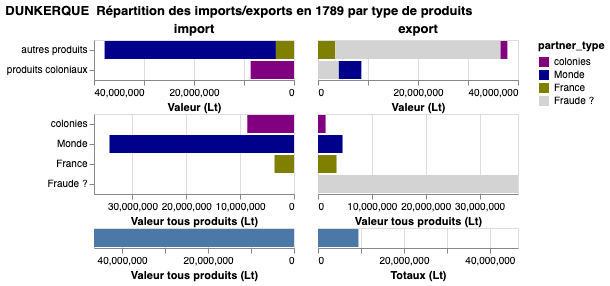

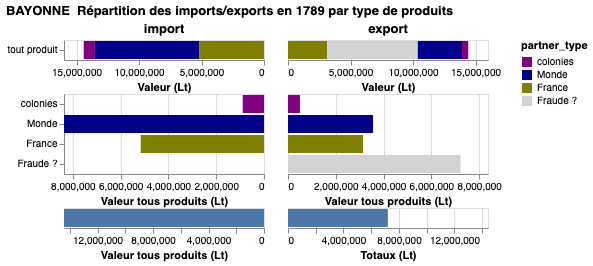

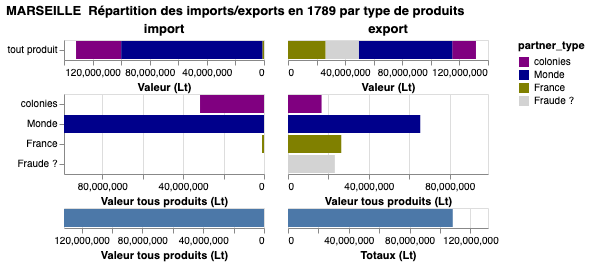

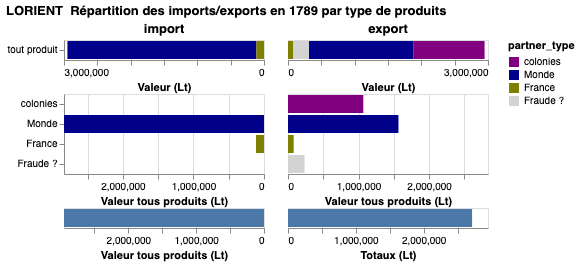

In [57]:
for city in ["Dunkerque", "Bayonne", "Marseille", "Lorient"]:
    pyramide_port_franc(city, data[city]["total_trade"],"product_type", "partner_type", "type de produits")

# Focus sur les exportations

Nous allons dans un premier temps détailler les produits coloniaux pour identifier les produits concernés par les anomalies d'exporations.

In [59]:
for city in ["Dunkerque", "Bayonne", "Marseille", "Lorient"]:
    pyramide_port_franc(city, data[city]["colonial_products"], "product", "partner_type", "produits coloniaux (révolution et empire)" if city == "Dunkerque" else "tout produit")

NameError: name 'port' is not defined